# Evaluate the optimal model
After training the optimal model via schedule lr (`pretrain_03.ipynb`), we evaluate the model on the validation set in the original spectral space. The training setting are as follows:
```
ViT model: base
Learning rate: warmup (10 epochs), constant (1e-5, 20 epochs), cosine decay (70 epochs)
Optimizer: AdamW (betas=(0.9, 0.95)) 
Clips gradient norm
Data pre-processing: spectrum-wise standardization
Patch size: 16
Mask ratio: 0.75
Batch size: 256
Epochs: 100
```

In [ ]:
import numpy as np
import torch
from util.datasets import get_dataloader, standardize
from util.evaluate import evaluate, evaluate_base, evaluate_inraw, inverse_standardize
from models_mae import mae_vit_base_patch16
import matplotlib.pyplot as plt

In [ ]:
# the base model
dataloader_raw = get_dataloader(annotations_file='data/info_20231225.csv', input_dir='data/pretrain', 
                                batch_size=256, transform=None)
mse_base_inraw = evaluate_base(dataloader_raw['val'])

# the model with standardization
dataloader_std = get_dataloader(annotations_file='data/info_20231225.csv', input_dir='data/pretrain', 
                                batch_size=256, transform=standardize)
model = mae_vit_base_patch16().to('cuda')
model.load_state_dict(torch.load('models/mae_vit_base_patch16_l-coslr_1e-05_20231229.pth'))
mse_model_inraw = evaluate_inraw(model, dataloader_raw['val'], dataloader_std['val'], inverse=inverse_standardize)

print(f'MSE: {round(mse_model_inraw, 1)}')
print(f'R2: {round(1 - mse_model_inraw / mse_base_inraw, 2)}')

MSE: 5469296.1
R2: 0.29


In [ ]:
mse_base_instd = evaluate_base(dataloader_std['val'])
mse_model_instd = evaluate(model, dataloader_std['val'])

print(f'MSE: {round(mse_model_instd, 3)}')
print(f'R2: {round(1 - mse_model_instd / mse_base_instd, 2)}')

MSE: 0.006
R2: 0.99


Well, the loss is not relevant between in the standardized and the original spectral spaces. MSE 5469296 is way too high. This MSE is calcualtated from the inversely transformed model predictions and target spectrum in the original space (equation `1` $MSE_a$). There is another way of MSE calculation: inversly transforming the MSE to the original space after it's calculated in the standardized space already (equation `2` $MSE_b$). These two $MSE$ should be able to be converted to each other via equation `3`. 

\begin{equation}
    MSE_a = \frac{1}{N} \sum_{i=1}^{N} [(T_i \times \sigma_i + \mu_i) - (P_i \times \sigma_i + \mu_i)]^2 \tag{1}
          \approx \frac{1}{N} \sum_{i=1}^{n} (T_i - P_i)^2 \times \sigma^2
\end{equation}

\begin{equation}
    MSE_b = \frac{1}{N} \sum_{i=1}^{N} (T_i - P_i)^2 \times \sigma + \mu \tag{2}
\end{equation}

\begin{equation}
    (MSE_b - \mu) \times \sigma \approx MSE_a \tag{3}
\end{equation}

where $T_i$ and $P_i$ are the target and predicted spectra (both in the standardized space), $\sigma_i$ and $\mu_i$ are the standard deviation and mean of each spectrum, $N$ is the number of spectra, $\sigma$ and $\mu$ are the standard deviation and mean of all spectra. I assume $\sigma_i$ is approximately equal to $\sigma$.

Let me calculate $MSE_b$ to see if I have error in the inverse transformation of $MSE_a$

In [ ]:
mean_inraw = np.mean(dataloader_raw['val'].dataset)
std_inraw = np.std(dataloader_raw['val'].dataset)
mse_std_inraw_b = (mse_model_instd * std_inraw + mean_inraw).item()


print(f'Mean: {round(mean_inraw, 1)}')
print(f'Std: {round(std_inraw, 1)}')
print(f'MSE: {round(mse_std_inraw_b, 1)}')

Mean: 508.7
Std: 2777.5
MSE: 526.7


In [ ]:
(mse_std_inraw_b - mean_inraw) * std_inraw

50063.54855637308

The two $MSE$ can't be converted to each other (not even in the same order), so there must be something wrong in the inverse transformation.

## Debug the inverse_transform
Only focus on the validation set.

In [3]:
import numpy as np
import torch
from util.datasets import CustomImageDataset, split, standardize
from models_mae import mae_vit_base_patch16
import matplotlib.pyplot as plt

In [ ]:
dataset = CustomImageDataset('data/info_20231225.csv', 'data/pretrain')
dataset_train, dataset_val = split(dataset)
print(f'Train size: {len(dataset_train)}')
print(f'Val size: {len(dataset_val)}')

Train size: 43715
Val size: 10928


In [ ]:
def plot_spectrum(pred_arr, target_arr, ylabel):
    plt.figure()
    plt.plot(pred_arr, label='pred')
    plt.plot(target_arr, label='target')
    plt.xlabel('Channel')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

    print(f'MSE: {np.mean((pred_arr - target_arr)**2)}')

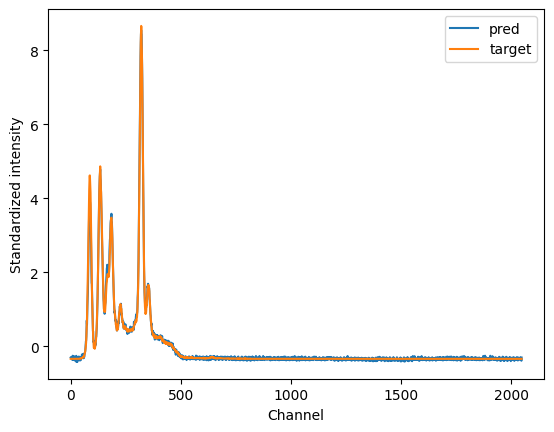

MSE: 0.0051666442304849625


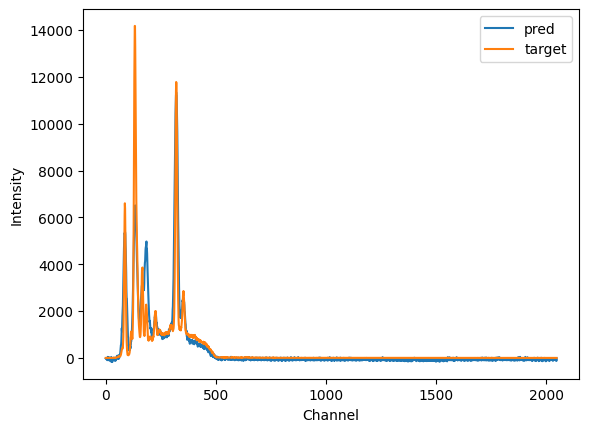

MSE: 401777.0625


In [ ]:
# plot the predicted and target spectra using the get_dataloader funciton in datasets.py
# some codes are omitted here

index = 22
plot_spectrum(pred_instd_arr[index], target_instd_arr[index], 'Standardized intensity')
plot_spectrum(pred_inraw_arr[index], target_inraw_arr[index], 'Intensity')

The inconsist order of the MSE between standardized and original spaces is reproduced. If we look closer, the target spectrum in two spaces look different. The standardization is a linear transformation only, so the target spectra should be the same shape. --> __inconsistency of the index between dataloaders?__

## Remove the randomness in the dataloader
Let's see if we make sure the data index is the same between dataloaders (instd, inraw), the problem can be solved. I remove the shuffling in the dataloader and loading the data from the same batch runs. 

In [11]:
from torch.utils.data import DataLoader

def get_dataloader(annotations_file: str, input_dir: str, batch_size: int, transform=None):
    dataset = CustomImageDataset(annotations_file, input_dir, transform=transform)
    data_train, data_val = split(dataset)
    dataloader = {
        'train':DataLoader(data_train, 
                           batch_size=batch_size),
        'val':DataLoader(data_val, 
                         batch_size=batch_size)
        }
    return dataloader

In [15]:
dataloader_inraw = get_dataloader(annotations_file='data/info_20231225.csv', input_dir='data/pretrain',
                            batch_size=256, transform=None)
dataloader_inraw = dataloader_inraw['val']

dataloader_instd = get_dataloader(annotations_file='data/info_20231225.csv', input_dir='data/pretrain', 
                            batch_size=256, transform=standardize)
dataloader_instd = dataloader_instd['val']   

model = mae_vit_base_patch16().to('cuda')
model.load_state_dict(torch.load('models/mae_vit_base_patch16_l-coslr_1e-05_20231229.pth'))
model.eval() 

target_inraw = torch.empty((0, 2048), device='cuda')
target_instd = torch.empty((0, 2048), device='cuda')
pred_instd = torch.empty((0, 2048), device='cuda')
mean_inraw_kpdim = []
std_inraw_kpdim = []

with torch.no_grad():
    for samples_inraw, samples_instd in zip(dataloader_inraw, dataloader_instd):
        samples_inraw = samples_inraw.to('cuda', non_blocking=True, dtype=torch.float)
        samples_instd = samples_instd.to('cuda', non_blocking=True, dtype=torch.float)
        
        target_inraw = torch.cat((target_inraw, samples_inraw), 0)
        target_instd = torch.cat((target_instd, samples_instd), 0)
        
        _, pred_batch, _ = model(samples_instd)
        pred_un = model.unpatchify(pred_batch)
        pred_instd = torch.cat((pred_instd, pred_un), 0)

        mean_inraw_kpdim = np.concatenate([mean_inraw_kpdim, samples_inraw.mean(dim=1).cpu().numpy()], axis=0)
        std_inraw_kpdim = np.concatenate([std_inraw_kpdim, samples_inraw.std(dim=1).cpu().numpy()], axis=0)

mean_inraw_kpdim = mean_inraw_kpdim.reshape(-1, 1)
std_inraw_kpdim = std_inraw_kpdim.reshape(-1, 1)

print(target_inraw.shape)
print(target_instd.shape)
print(pred_instd.shape)
print(mean_inraw_kpdim.shape)
print(std_inraw_kpdim.shape)

torch.Size([10928, 2048])
torch.Size([10928, 2048])
torch.Size([10928, 2048])
(10928, 1)
(10928, 1)


In [16]:
pred_instd_arr = pred_instd.cpu().numpy()
pred_inraw_arr = pred_instd_arr * std_inraw_kpdim + mean_inraw_kpdim

target_instd_arr = target_instd.cpu().numpy()
target_inraw_arr = target_inraw.cpu().numpy()

In [18]:
print(f'MSEa after removing shuffling in the dataloader: {np.mean((pred_inraw_arr - target_inraw_arr)**2):.2f}')

MSEa after removing shuffling in the dataloader: 29466.77


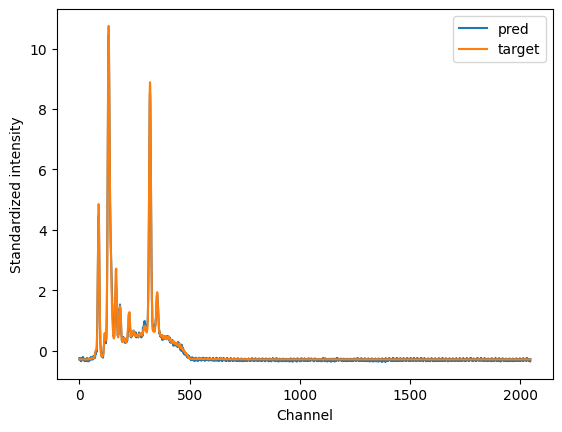

MSE: 0.004222360905259848


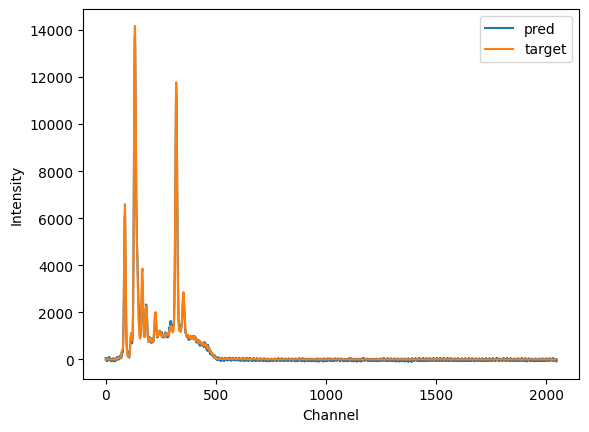

MSE: 6944.928628838736


In [20]:
index = 22
plot_spectrum(pred_instd_arr[index], target_instd_arr[index], 'Standardized intensity')
plot_spectrum(pred_inraw_arr[index], target_inraw_arr[index], 'Intensity')

Now the MSE reduces to the reasonable level, which the order is relevant to the MSE in the standardized space. The target spectra is identical. The randomness in dataloader really matters.

But, actually the MSE is corrected to be too small. It still can't be converted perfectly via equation `3`. Perhaps, there is something else wrong, but seems to be minor...or is the cost of approximation?

## Fix the bug
Simply turn off the shuffling in the function `get_dataloader` in `dataset.py` regarding the validation set. The shuffling is still kept in training set to enforce the learning.

In [1]:
import torch
from util.datasets import get_dataloader, standardize
from util.evaluate import evaluate_base, evaluate_inraw, inverse_standardize
from models_mae import mae_vit_base_patch16

In [3]:
# the base model
dataloader_raw = get_dataloader(annotations_file='data/info_20231225.csv', input_dir='data/pretrain', 
                                batch_size=256, transform=None)
mse_base_inraw = evaluate_base(dataloader_raw['val'])

# the model with standardization
dataloader_std = get_dataloader(annotations_file='data/info_20231225.csv', input_dir='data/pretrain', 
                                batch_size=256, transform=standardize)
model = mae_vit_base_patch16().to('cuda')
model.load_state_dict(torch.load('models/mae_vit_base_patch16_l-coslr_1e-05_20231229.pth'))
mse_model_inraw = evaluate_inraw(model, dataloader_raw['val'], dataloader_std['val'], inverse=inverse_standardize)

print(f'MSE: {round(mse_model_inraw, 1)}')
print(f'R2: {round(1 - mse_model_inraw / mse_base_inraw, 4)}')

MSE: 29445.5
R2: 0.9962


Now, it works. The original space's MSE calculation in the previous notebooks are wrong, underestimating the model performance.

Let me check if the results change.

In [5]:
# the result from pretrain_01.py
mse_base = evaluate_base(dataloader_raw['val'])
model = mae_vit_base_patch16().to('cuda')
model.load_state_dict(torch.load('models/mae_vit_base_patch16_1e-05_20231214.pth'))
mse_std = evaluate_inraw(model, dataloader_raw['val'], dataloader_std['val'], inverse=inverse_standardize)

print(f'MSE: {round(mse_std, 1)}')
print(f'R2: {round(1 - mse_std / mse_base, 4)}')

MSE: 76268.9
R2: 0.9901


In [6]:
# the result from pilot_11.py

# the base model
dataloader_raw = get_dataloader(annotations_file='pilot/data/info_20231121.csv', input_dir='pilot/data/spe',
                                batch_size=64, transform=None)
mse_base = evaluate_base(dataloader_raw['val'])

# the model with standardization
dataloader_std = get_dataloader(annotations_file='pilot/data/info_20231121.csv', input_dir='pilot/data/spe',
                                batch_size=64, transform=standardize)
model = mae_vit_base_patch16().to('cuda')
model.load_state_dict(torch.load('pilot/models/mae_vit_base_patch16_update_1e-05_20231214.pth'))
mse_std = evaluate_inraw(model, dataloader_raw['val'], dataloader_std['val'], inverse=inverse_standardize)

print(f'MSE: {round(mse_std, 1)}')
print(f'R2: {round(1 - mse_std / mse_base, 2)}')

MSE: 110203.4
R2: 0.99


The previous models' performance was indeed underestimated. I also checked the pilot models used for determining the optimal model (std or ln). The decision is the same, except the std model outperforms more than it was estimated. Details are in `pilot/pilot_10.ipynb`.